# TensorFlow2 DenseNet-BiLSTM-CRF

## 1. Input

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
# import tensorflow_addons as tfa
# from tensorflow_addons.layers import CRF
import os.path 
# from keras_contrib.layers import CRF
# from tf_keras_contrib.layers import CRF


In [5]:
txt_file = 'sc/train20.txt'
# txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
speeds = []
time_train = []
for line in f.readlines():
    filename = line.split(',')[0]
    time = filename.split('.')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspaths.append(filename)
        time_train.append(int(time))
        speeds.append(int(speed))
    
y_train = np.array(speeds)
time_train = np.array(time_train)


In [6]:
max_unit = np.max(speeds)

In [7]:
txt_file = 'sc/test20.txt'
# txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
speeds = []
time_test = []
for line in f.readlines():
    filename = line.split(',')[0]
    time = filename.split('.')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspath2.append(filename)
        time_test.append(int(time))
        speeds.append(int(speed))
y_test = np.array(speeds)
time_test = np.array(time_test)
        

In [8]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [9]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [10]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [11]:
time_train = np.reshape(time_train,(time_train.shape[0],1,1))
time_test = np.reshape(time_test,(time_test.shape[0],1,1))

In [12]:
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(20712, 32, 32, 3)   (20712, 100)
(5178, 32, 32, 3)   (5178, 100)


In [13]:
validation_set = ([x_test, time_test], y_test)

## 2. Model

In [14]:
from tensorflow.keras import layers
model = keras.Sequential()

In [15]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [16]:
outt = layers.Dense(max_unit+1,activation='softmax')(dense1)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                122944    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
Total params: 18,451,428
Trainable params: 18,222,372
Non-trainable params: 229,056
_________________________________________________________________


In [17]:
%%time
history2 = model.fit([x_train, time_train], y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
324/324 [==============================] - 264s 814ms/step - loss: 2.4099 - accuracy: 0.2482 - val_loss: 5.9955 - val_accuracy: 0.0593
Epoch 2/200
324/324 [==============================] - 277s 855ms/step - loss: 1.9719 - accuracy: 0.3443 - val_loss: 2.8897 - val_accuracy: 0.1966
Epoch 3/200
324/324 [==============================] - 278s 857ms/step - loss: 1.5949 - accuracy: 0.4396 - val_loss: 1.7074 - val_accuracy: 0.4208
Epoch 4/200
324/324 [==============================] - 263s 813ms/step - loss: 1.2922 - accuracy: 0.5268 - val_loss: 1.8156 - val_accuracy: 0.4206
Epoch 5/200
324/324 [==============================] - 262s 809ms/step - loss: 1.1182 - accuracy: 0.5863 - val_loss: 2.0898 - val_accuracy: 0.3712
Epoch 6/200
324/324 [==============================] - 261s 807ms/step - loss: 1.0131 - accuracy: 0.6212 - val_loss: 2.1811 - val_accuracy: 0.3992
Epoch 7/200
324/324 [==============================] - 264s 815ms/step - loss: 0.9005 - accuracy: 0.6591 - val_loss: 2

324/324 [==============================] - 147s 453ms/step - loss: 0.1468 - accuracy: 0.9490 - val_loss: 5.1825 - val_accuracy: 0.3395
Epoch 57/200
324/324 [==============================] - 148s 456ms/step - loss: 0.1355 - accuracy: 0.9545 - val_loss: 2.4577 - val_accuracy: 0.5415
Epoch 58/200
324/324 [==============================] - 142s 439ms/step - loss: 0.1295 - accuracy: 0.9548 - val_loss: 1.6391 - val_accuracy: 0.6543
Epoch 59/200
324/324 [==============================] - 143s 442ms/step - loss: 0.1279 - accuracy: 0.9567 - val_loss: 1.4414 - val_accuracy: 0.6802
Epoch 60/200
324/324 [==============================] - 142s 437ms/step - loss: 0.1256 - accuracy: 0.9563 - val_loss: 1.0543 - val_accuracy: 0.7499
Epoch 61/200
324/324 [==============================] - 141s 434ms/step - loss: 0.1277 - accuracy: 0.9593 - val_loss: 1.0981 - val_accuracy: 0.7381
Epoch 62/200
324/324 [==============================] - 148s 457ms/step - loss: 0.1145 - accuracy: 0.9626 - val_loss: 1.7127 

324/324 [==============================] - 139s 430ms/step - loss: 0.0576 - accuracy: 0.9815 - val_loss: 1.9047 - val_accuracy: 0.6474
Epoch 112/200
324/324 [==============================] - 141s 435ms/step - loss: 0.0546 - accuracy: 0.9839 - val_loss: 1.3341 - val_accuracy: 0.7431
Epoch 113/200
324/324 [==============================] - 142s 440ms/step - loss: 0.0660 - accuracy: 0.9797 - val_loss: 1.6476 - val_accuracy: 0.6873
Epoch 114/200
324/324 [==============================] - 142s 440ms/step - loss: 0.0620 - accuracy: 0.9817 - val_loss: 1.5980 - val_accuracy: 0.7144
Epoch 115/200
324/324 [==============================] - 141s 436ms/step - loss: 0.0558 - accuracy: 0.9828 - val_loss: 2.3951 - val_accuracy: 0.6058
Epoch 116/200
324/324 [==============================] - 143s 440ms/step - loss: 0.0683 - accuracy: 0.9780 - val_loss: 1.8241 - val_accuracy: 0.6898
Epoch 117/200
324/324 [==============================] - 142s 439ms/step - loss: 0.0714 - accuracy: 0.9773 - val_loss: 1

324/324 [==============================] - 151s 467ms/step - loss: 0.0508 - accuracy: 0.9858 - val_loss: 2.9979 - val_accuracy: 0.5554
Epoch 167/200
324/324 [==============================] - 142s 437ms/step - loss: 0.0603 - accuracy: 0.9819 - val_loss: 2.9416 - val_accuracy: 0.5620
Epoch 168/200
324/324 [==============================] - 151s 465ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 1.1947 - val_accuracy: 0.7822
Epoch 169/200
324/324 [==============================] - 147s 453ms/step - loss: 0.0271 - accuracy: 0.9915 - val_loss: 1.5682 - val_accuracy: 0.7244
Epoch 170/200
324/324 [==============================] - 150s 462ms/step - loss: 0.0442 - accuracy: 0.9863 - val_loss: 2.4106 - val_accuracy: 0.6159
Epoch 171/200
324/324 [==============================] - 148s 457ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 1.4097 - val_accuracy: 0.7445
Epoch 172/200
324/324 [==============================] - 144s 444ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 2

In [18]:
model.evaluate(x=[x_test, time_test],y=y_test,verbose=1)

162/162 [==============================] - 7s 42ms/step - loss: 1.4980 - accuracy: 0.7543


[1.4980367422103882, 0.7543452978134155]

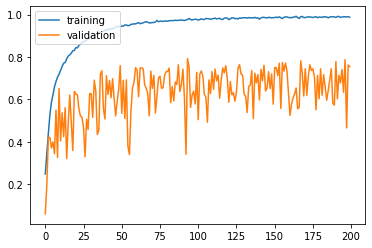

In [19]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [22]:
np.max(history2.history['accuracy'])

0.9925163984298706

In [23]:
np.max(history2.history['val_accuracy'])

0.7927771210670471